In [1]:
#-------------------------------------------------------------------------------
# Define all required libraries, routines, and modules
#-------------------------------------------------------------------------------
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import sys
import mpl_toolkits.basemap
import os
import PIL


In [2]:
#-------------------------------------------------------------------------------
# Define all required sub-libraries, sub-routines, and sub-modules
#-------------------------------------------------------------------------------
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.patches import Polygon


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#-------------------------------------------------------------------------------
# Define all input/out files and directories 
#-------------------------------------------------------------------------------
input_file = '/Volumes/Black_box/Data/USeast-age/output/clim/averages/avg_3hrly.nc'
grid_file  = '/Volumes/Black_box/Data/USeast/Data/grd/USeast-grid.nc'
ATL_file   = '/Volumes/Black_box/Data/USeast/Data/grd/grid_ATLscope.nc'
GOM_file   = '/Volumes/Black_box/Data/USeast/Data/grd/grid_GOMscope.nc'
GOMs_file  = '/Volumes/Black_box/Data/USeast/Data/grd/grid_GOM_shelf_scope.nc'
cmap_file  = '/Users/actodd/Documents/ROMS-utils/USeast/ElevationBathymetryColormap/etopo1.clr'
river_file = '/Volumes/Black_box/Data/USeast/Data/frc/USeast-riverNOVN-12.nc'
plot_file  = '/Volumes/Black_box/Data/PLOTS/USeast-age/domain/map_ocean.png'


In [5]:
#-------------------------------------------------------------------------------
# Open grid file and read in standard variables
#-------------------------------------------------------------------------------
print 'Ingesting data from file %s ...' % (grid_file)
grid_data=Dataset(grid_file,mode='r')
hmask= grid_data.variables['mask_rho' ][:,0:401-25]
h    = grid_data.variables['h'        ][:,0:401-25]
hraw = grid_data.variables['hraw'     ][0,:,0:401-25]
lon =grid_data.variables['lon_rho'    ][:,0:401-25]
lonu=grid_data.variables['lon_u'      ][:]
lonv=grid_data.variables['lon_v'      ][:]
lat =grid_data.variables['lat_rho'    ][:,0:401-25]
latu=grid_data.variables['lat_u'      ][:]
latv=grid_data.variables['lat_v'      ][:]
grid_data.close()


Ingesting data from file /Volumes/Black_box/Data/USeast/Data/grd/USeast-grid.nc ...


In [44]:
lon2=lon+0.5*(lon[1,2]-lon[1,1])
lat2=lat+0.5*(lat[2,1]-lat[1,1])

In [19]:
#-------------------------------------------------------------------------------
# Open ATL/GOM/GOM shelf files and read in scopes
#-------------------------------------------------------------------------------
print 'Ingesting data from file %s ...' % (ATL_file)
grid_data=Dataset(ATL_file,mode='r')
Ascope= grid_data.variables['scope_rho' ][:,0:401-25]
grid_data.close()

print 'Ingesting data from file %s ...' % (GOMs_file)
grid_data=Dataset(GOMs_file,mode='r')
Gscope= grid_data.variables['scope_rho' ][:,0:401-25]
grid_data.close()

Sscope=Ascope+Gscope

print 'Ingesting data from file %s ...' % (GOM_file)
grid_data=Dataset(GOM_file,mode='r')
Gscope= grid_data.variables['scope_rho' ][:,0:401-25]
grid_data.close()


Ingesting data from file /Volumes/Black_box/Data/USeast/Data/grd/grid_ATLscope.nc ...
Ingesting data from file /Volumes/Black_box/Data/USeast/Data/grd/grid_GOM_shelf_scope.nc ...
Ingesting data from file /Volumes/Black_box/Data/USeast/Data/grd/grid_GOMscope.nc ...


In [7]:
#-------------------------------------------------------------------------------
# Open river file and read in variables
#-------------------------------------------------------------------------------
print 'Ingesting data from file %s ...' % (river_file)
river_data=Dataset(river_file,mode='r')
river_X    =river_data.variables['river_Xposition'][:]
river_Y    =river_data.variables['river_Eposition'][:]
river_trans=river_data.variables['river_transport'][:]
river_dir  =river_data.variables['river_direction'][:]
river_flag =river_data.variables['river_flag'     ][:]
river_data.close()

river_lon =np.zeros(shape=(len(river_X)))
river_lat =np.zeros(shape=(len(river_X)))
river_size=np.zeros(shape=(len(river_X)))
river_trans=np.mean(river_trans,axis=0)


Ingesting data from file /Volumes/Black_box/Data/USeast/Data/frc/USeast-riverNOVN-12.nc ...


In [8]:
#-------------------------------------------------------------------------------
# Set river mouth lat/lons and scale direction
#-------------------------------------------------------------------------------
for i in range(0,len(river_X)):
  if river_dir[i]:
    river_lon[ i]=lonv[river_Y[i],river_X[i]]
    river_lat[ i]=latv[river_Y[i],river_X[i]]
    river_size[i]=np.abs(river_trans[i])
  else:
    river_lon[ i]=lonu[river_Y[i],river_X[i]]
    river_lat[ i]=latu[river_Y[i],river_X[i]]
    river_size[i]=np.abs(river_trans[i])


In [22]:
#-------------------------------------------------------------------------------
# Mask the age variables to the shelf
#-------------------------------------------------------------------------------
hraw=np.where(hraw>0.0,0.0,1.0)
for i in range(0,482):
  for j in range(0,401-25):
    if (hraw[i,j]==1.0):
      if (hmask[i,j]==1.0):
        hraw[i,j]=0.0
h=np.ma.array(h,mask=hraw)
cm.ocean.set_bad('white',alpha=0)

Gmask=1-Gscope
Gmask=np.ma.array(Gmask,mask=Gmask)

Smask=1-Sscope
Smask=np.ma.array(Smask,mask=Smask)


Saving figure to file /Volumes/Black_box/Data/PLOTS/USeast-age/domain/map_ocean.png 


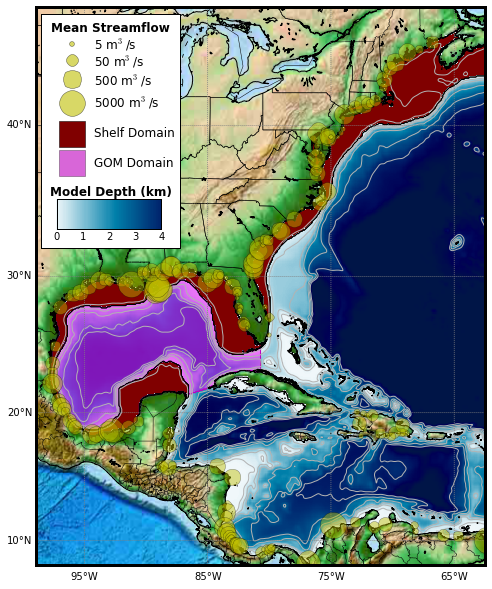

In [79]:
fig=plt.figure(num=None, figsize=(10, 10), dpi=300, facecolor='w')
m=Basemap(projection='merc',llcrnrlat=lat.min(),urcrnrlat=lat.max(),\
          llcrnrlon=lon.min(),urcrnrlon=lon.max(),lat_ts=20,resolution='f')

# Draw a thick border around the whole map
m.drawmapboundary(fill_color='white',linewidth=3)

# Plot Data
xi, yi = m(lon,lat)
cs = m.pcolormesh(xi,yi,-h,cmap=cm.ocean,vmin=-7000, vmax=150)
#cSs= m.pcolormesh(xi,yi,Smask,cmap=cm.jet,vmin=-1, vmax=0,alpha=0.1)
Mc1= m.contourf(xi,yi,Gmask,levels=[0,0],cmap=cm.cool,vmin=-1, vmax=0, alpha=0.5)
Mc = m.contourf(xi,yi,Smask,levels=[0,0],cmap=cm.jet,vmin=-1, vmax=0)
cM1 = m.contour(   xi,yi,Gscope,[0.5,0.5],colors='m',linewidth=3.0)
cM = m.contour(   xi,yi,Sscope,[0.5,0.5],colors='k',linewidth=2.0)

# Contour depths (but first mask Pacific)
h=np.ma.array(h,mask=1.0-hmask)
cn = m.contour(xi,yi,h,[100,500,1000,2000,3000,4000],linewidth=1.5,colors='0.7')

# Add Grid Lines
m.drawparallels(np.arange(0.,90.,10.), labels=[1,0,0,0],\
                fontsize=10, linewidth=0.75, color='.5')
m.drawmeridians(np.arange(-105.,-35.,10.), labels=[0,0,0,1],\
                fontsize=10, linewidth=0.75, color='.5')

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.etopo()
#m.bluemarble()
#m.fillcontinents(color='grey')

# Add river points scattered and sized by river output
x,y = m(river_lon,river_lat)
for j in range(0,len(river_lon)):
  m.plot(x[j],y[j],markersize=np.log(river_size[j])*3,marker='o',color='y',alpha=0.45)

# Add Rectangle as base for legend
lns=[-98.5,-87.25,-87.25,-98.5]
#lts=[38,38,46.1,46.1]
lts=[32,32,46.6,46.6]
x,y = m(lns,lts)
xy = zip(x,y)
poly = Polygon( xy, facecolor='white')
pt= plt.gca().add_patch(poly)
pt.set_zorder(3)

# Add Scale circles for legend
lns=[-96,-96,-96,-96,-96]
lts=[ 44.85, 43.95, 42.85, 41.4, 39.75]
x1,y1 = m(lns,lts)
m.plot(x1[0],y1[0],markersize=np.log(   5.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
m.plot(x1[1],y1[1],markersize=np.log(  50.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
m.plot(x1[2],y1[2],markersize=np.log( 500.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
m.plot(x1[3],y1[3],markersize=np.log(5000.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
#m.plot(x1[4],y1[4],markersize=np.log(5000.0)*3,marker='o',color='y',alpha=0.6,zorder=4)

# Print text next to each circle
lns=[-94.25,-94.25,-94.25,-94.25,-94.25,-94.25]
lts=[ 44.85, 43.85, 42.75, 41.4, 40.2, 39.35]
x1,y1 = m(lns,lts)
plt.text(x1[0],y1[0],'5 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[1],y1[1],'50 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[2],y1[2],'500 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[3],y1[3],'5000 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
#plt.text(x1[4],y1[4],'Mississippi /',fontsize=12,ha='left',va='center',color='k')
#plt.text(x1[5],y1[5],'Atchafalaya',fontsize=12,ha='left',va='center',color='k')

# Print legend title
x1,y1 = m([-92.875],[45.75])
plt.text(x1[0],y1[0],'Mean Streamflow',fontsize=12,fontweight='bold',ha='center',va='center',color='k')

# Add Scale squares for legend of Scopes
lns=[-96,-96]
lts=[ 39.5,37.65 ]
x1,y1 = m(lns,lts)
m.plot(x1[0],y1[0],markersize=np.log(5000.0)*3,marker='s',color=[.5,0,0],alpha=1,zorder=4)
m.plot(x1[1],y1[1],markersize=np.log(5000.0)*3,marker='s',color='m',alpha=0.6,zorder=4)

# Print text next to each circle
lns=[-94.25,-94.25]
lts=[ 39.5, 37.65]
x1,y1 = m(lns,lts)
plt.text(x1[0],y1[0],'GOM Shelf Domain',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[1],y1[1],'Atlantic Shelf Domain',fontsize=12,ha='left',va='center',color='k')

# Create patch as a bathymetry colorbar
a  =np.arange(0,1.01,0.01)
lns=np.array([[(a*(-88.75+97.25))-97.25],[(a*(-88.75+97.25))-97.25]]).squeeze()
lts=np.array([[a*0+33.25],[a*0+35.25]]).squeeze()
bth=np.array([[a*-4000],[a*-4000]]).squeeze()
x2,y2 = m(lns,lts)
cbs=m.pcolormesh(x2,y2,bth, cmap=cm.ocean, vmin=-7000, vmax=150)
cbs.set_zorder(4)

# Make lines around Colorbar
m.plot(x2[0,:],y2[0,:],color='k',linewidth=1,zorder=4)
m.plot(x2[1,:],y2[1,:],color='k',linewidth=1,zorder=4)
m.plot(x2[:,0],y2[:,0],color='k',linewidth=1,zorder=4)
m.plot(x2[:,100],y2[:,100],color='k',linewidth=1,zorder=4)

# Write ticks below colorbar
plt.text(x2[0,0],y2[0,0]-18000,'0',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,25],y2[0,25]-18000,'1',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,50],y2[0,50]-18000,'2',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,75],y2[0,75]-18000,'3',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,100],y2[0,100]-18000,'4',fontsize=10,ha='center',va='top',color='k')

# Print Colorbar title
x1,y1 = m([-92.875,-92.875],[35.75,34.9])
plt.text(x1[0],y1[0],'Model Depth (km)',fontsize=12,fontweight='bold',ha='center',va='center',color='k')

# Save figure to file
print 'Saving figure to file %s ' % plot_file
plt.savefig(plot_file,dpi=300,bbox_inches='tight')


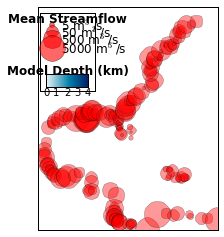

In [49]:
# Add river points scattered and sized by river output
x,y = m(river_lon,river_lat)
for j in range(0,len(river_lon)):
  m.plot(x[j],y[j],markersize=np.log(river_size[j])*3,marker='o',color='r',alpha=0.4)

# Add Rectangle as base for legend
lns=[-98.5,-87.25,-87.25,-98.5]
#lts=[38,38,46.1,46.1]
lts=[34,34,46.1,46.1]
x,y = m(lns,lts)
xy = zip(x,y)
poly = Polygon( xy, facecolor='white')
pt= plt.gca().add_patch(poly)
pt.set_zorder(3)

# Add Scale circles for legend
lns=[-96,-96,-96,-96,-96]
lts=[ 44.35, 43.45, 42.35, 40.9, 39.25]
x1,y1 = m(lns,lts)
m.plot(x1[0],y1[0],markersize=np.log(   5.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
m.plot(x1[1],y1[1],markersize=np.log(  50.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
m.plot(x1[2],y1[2],markersize=np.log( 500.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
m.plot(x1[3],y1[3],markersize=np.log(5000.0)*3,marker='o',color='r',alpha=0.6,zorder=4)
#m.plot(x1[4],y1[4],markersize=np.log(5000.0)*3,marker='o',color='y',alpha=0.6,zorder=4)

# Print text next to each circle
lns=[-94.25,-94.25,-94.25,-94.25,-94.25,-94.25]
lts=[ 44.35, 43.35, 42.25, 40.9, 39.7, 38.85]
x1,y1 = m(lns,lts)
plt.text(x1[0],y1[0],'5 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[1],y1[1],'50 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[2],y1[2],'500 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
plt.text(x1[3],y1[3],'5000 m$^3$/s',fontsize=12,ha='left',va='center',color='k')
#plt.text(x1[4],y1[4],'Mississippi /',fontsize=12,ha='left',va='center',color='k')
#plt.text(x1[5],y1[5],'Atchafalaya',fontsize=12,ha='left',va='center',color='k')

# Print legend title
x1,y1 = m([-92.875],[45.25])
plt.text(x1[0],y1[0],'Mean Streamflow',fontsize=12,fontweight='bold',ha='center',va='center',color='k')


# Create patch as a bathymetry colorbar
a  =np.arange(0,1.01,0.01)
lns=np.array([[(a*(-88.75+97.25))-97.25],[(a*(-88.75+97.25))-97.25]]).squeeze()
lts=np.array([[a*0+34.75],[a*0+36.75]]).squeeze()
bth=np.array([[a*-4000],[a*-4000]]).squeeze()
x2,y2 = m(lns,lts)
cbs=m.pcolormesh(x2,y2,bth, cmap=cm.ocean, vmin=-7000, vmax=150)
cbs.set_zorder(4)

# Make lines around Colorbar
m.plot(x2[0,:],y2[0,:],color='k',linewidth=1,zorder=4)
m.plot(x2[1,:],y2[1,:],color='k',linewidth=1,zorder=4)
m.plot(x2[:,0],y2[:,0],color='k',linewidth=1,zorder=4)
m.plot(x2[:,100],y2[:,100],color='k',linewidth=1,zorder=4)

# Write ticks below colorbar
plt.text(x2[0,0],y2[0,0]-1000,'0',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,25],y2[0,25]-12000,'1',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,50],y2[0,50]-12000,'2',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,75],y2[0,75]-12000,'3',fontsize=10,ha='center',va='top',color='k')
plt.text(x2[0,100],y2[0,100]-12000,'4',fontsize=10,ha='center',va='top',color='k')


# Print Colorbar title
x1,y1 = m([-92.875,-92.875],[37.4,36.55])
plt.text(x1[0],y1[0],'Model Depth (km)',fontsize=12,fontweight='bold',ha='center',va='center',color='k')


In [70]:
colors.Colormap('jet')

AttributeError: 'function' object has no attribute 'Colormap'